# 環境情報表示

In [ ]:
# メモリ
!free -h

              total        used        free      shared  buff/cache   available
Mem:            25G        584M         22G        1.2M        2.8G         24G
Swap:            0B          0B          0B


In [ ]:
# GPU情報
!nvidia-smi

Sun Dec  4 13:16:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 準備

In [ ]:
# Google Drive に接続
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ワーキングディレクトリを設定
full_path = '/content/drive/MyDrive/DiseaseClassification/'

In [ ]:
# Python基本ライブラリ
import sys
import gc
import datetime
import os
import random
import pathlib
from tqdm import tqdm_notebook as tqdm
import re
import warnings
warnings.filterwarnings('ignore')

# データ処理ライブラリ
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix
import seaborn as sns
# !pip install -U albumentations
import albumentations as A
from google.colab.patches import cv2_imshow

# 深層学習ライブラリ
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision import models, transforms
import torchvision
# !pip install pretrainedmodels
# !pip install efficientnet_pytorch
# import pretrainedmodels
# from efficientnet_pytorch import EfficientNet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# timmのモデルを使用
!pip install timm
import timm
model_names = timm.list_models(pretrained=True)
print(model_names[0:6])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 549 kB 4.9 MB/s 
     |████████████████████████████████| 182 kB 79.5 MB/s 
['adv_inception_v3', 'bat_resnext26ts', 'beit_base_patch16_224', 'beit_base_patch16_224_in22k', 'beit_base_patch16_384', 'beit_large_patch16_224']


In [ ]:
#主要ライブラリのバージョン表示
print('主要ライブラリバージョン')
print('  Python  : ', sys.version)
print('  Pandas  : ', pd.__version__)
print('  Numpy   : ', np.__version__)
print('  torch   : ', torch.__version__)

主要ライブラリバージョン
  Python  :  3.8.15 (default, Oct 12 2022, 19:14:39) 
[GCC 7.5.0]
  Pandas  :  1.3.5
  Numpy   :  1.21.6
  torch   :  1.12.1+cu113


In [ ]:
# ランダムシードの設定
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
seed = 42

In [ ]:
def softmax(out):
    tmp = np.exp(out[:,0])+np.exp(out[:,1])
    return(np.exp(out[:,1]) / tmp)

# 深層学習

## 各種定義
ネットワークやデータセットなどの定義を行います。

In [ ]:
# ネットワークの定義
class EfficientnetXX(nn.Module):
    def __init__(self, pretrained='imagenet', net_type="efficientnet_b0", class_num=20):
        super(EfficientnetXX, self).__init__()
        self.base_model = timm.create_model(net_type, pretrained=True)
        self.base_model.classifier = nn.Linear(self.base_model.classifier.in_features, class_num)
    
    def forward(self, image, targets):
        batch_size, _, _, _ = image.shape
        out = self.base_model(image)
        loss = nn.CrossEntropyLoss()(out, targets)
        return out, loss

class SEResnextXX(nn.Module):
    def __init__(self, pretrained='imagenet', net_type=None, class_num=20):
        super(SEResnextXX, self).__init__()
        self.base_model = pretrainedmodels.__dict__[net_type](pretrained=pretrained)
    
    def forward(self, image, targets):
        batch_size, _, _, _ = image.shape
        x = self.base_model.features(image)
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch_size, -1)
        out = self.l0(x)
        loss = nn.CrossEntropyLoss()(out, targets)
        return out, loss

In [ ]:
# 基本機能
class Engine:
    @staticmethod
    def train(
        data_loader,
        model,
        optimizer,
        device,
        epoch=0,
        scheduler=None,
        accumulation_steps=1,
    ):
        losses = AverageMeter()
        predictions = []
        model.train()
        if accumulation_steps > 1:
            optimizer.zero_grad()
        
        if epoch==0:
            tk0 = tqdm(data_loader, total=len(data_loader))
        else:
            tk0 = data_loader
            
        for b_idx, data in enumerate(tk0):
            for key, value in data.items():
                data[key] = value.to(device)
            if accumulation_steps == 1 and b_idx == 0:
                optimizer.zero_grad()
            _, loss = model(**data)

            with torch.set_grad_enabled(True):
                loss.backward()
                if (b_idx + 1) % accumulation_steps == 0:
                    optimizer.step()
                    if scheduler is not None:
                        scheduler.step()
                    if b_idx > 0:
                        optimizer.zero_grad()
            losses.update(loss.item(), data_loader.batch_size)

            if epoch==0:
                tk0.set_postfix(loss=losses.avg)

        return losses.avg

    @staticmethod
    def evaluate(data_loader, model, device, epoch=0):
        losses = AverageMeter()
        final_predictions = []
        model.eval()
        with torch.no_grad():
            if epoch==0:
                tk0 = tqdm(data_loader, total=len(data_loader))
            else:
                tk0 = data_loader
            for b_idx, data in enumerate(tk0):
                for key, value in data.items():
                    data[key] = value.to(device)
                predictions, loss = model(**data)
                predictions = predictions.cpu()
                losses.update(loss.item(), data_loader.batch_size)
                final_predictions.append(predictions)

                if epoch==0:
                    tk0.set_postfix(loss=losses.avg)
                
        return final_predictions, losses.avg

    @staticmethod
    def predict(data_loader, model, device):
        model.eval()
        final_predictions = []
        with torch.no_grad():
            tk0 = data_loader
            for b_idx, data in enumerate(tk0):
                for key, value in data.items():
                    data[key] = value.to(device)
                predictions, _ = model(**data)
                predictions = predictions.cpu()
                final_predictions.append(predictions)
        return final_predictions

In [ ]:
# データセット定義
class ClassificationDataset:
    def __init__(
        self,
        image_paths,
        targets,
        resize,
        augmentations=None,
    ):
        """
        :param image_paths: list of paths to images
        :param targets: numpy array
        :param resize: tuple or None
        :param augmentations: albumentations augmentations
        """
        self.image_paths = image_paths
        self.targets = targets
        self.resize = resize
        self.augmentations = augmentations

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, item):
        targets = self.targets[item]
        image = self.image_paths[item]
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        if self.resize is not None:
            image = cv2.resize(
                image,
                (self.resize[1], self.resize[0]),
                interpolation=cv2.INTER_CUBIC,
            )
        if self.augmentations is not None:
            augmented = self.augmentations(image=image)
            image = augmented["image"]
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        return {
            "image": torch.tensor(image),
            "targets": torch.tensor(targets, dtype=torch.long),
        }

In [ ]:
# データローダー定義
class ClassificationDataLoader:
    def __init__(
        self,
        image_paths,
        targets,
        resize,
        augmentations=None,
        backend="cv2",
        channel_first=True,
    ):
        """
        :param image_paths: list of paths to images
        :param targets: numpy array
        :param resize: tuple or None
        :param augmentations: albumentations augmentations
        """
        self.image_paths = image_paths
        self.targets = targets
        self.resize = resize
        self.augmentations = augmentations
        self.backend = backend
        self.channel_first = channel_first
        self.dataset = ClassificationDataset(
            image_paths=self.image_paths,
            targets=self.targets,
            resize=self.resize,
            augmentations=self.augmentations,
            backend=self.backend,
            channel_first=self.channel_first,
        )

    def fetch(
        self,
        batch_size,
        num_workers,
        drop_last=False,
        shuffle=True,
        sampler=None,
    ):
        """
        :param batch_size: batch size
        :param num_workers: number of processes to use
        :param drop_last: drop the last batch?
        :param shuffle: True/False
        """
        data_loader = torch.utils.data.DataLoader(
            self.dataset,
            batch_size=batch_size,
            sampler=sampler,
            drop_last=drop_last,
            num_workers=num_workers,
        )
        return data_loader

In [ ]:
# 早期終了設定
class EarlyStopping:
    def __init__(self, patience=7, mode="max", delta=0.0001):
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        if self.mode == "min":
            self.val_score = np.Inf
        else:
            self.val_score = -np.Inf

    def __call__(self, epoch_score, model, model_path):
        if self.mode == "min":
            score = -1.0 * epoch_score
        else:
            score = np.copy(epoch_score)

        if self.best_score is None:  # 最初にベストスコアを設定
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
        elif score < self.best_score + self.delta:  # ベストスコア未満だった場合はカウンタをインクリメント
            self.counter += 1
            print("EarlyStopping counter: {} out of {}".format(self.counter, self.patience))
            if self.counter >= self.patience:
                self.early_stop = True
        else:  # ベストスコアだった場合はモデルを保存
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
            self.counter = 0

    def save_checkpoint(self, epoch_score, model, model_path):
        if epoch_score not in [-np.inf, np.inf, -np.nan, np.nan]:
            print("Validation score improved ({} --> {}). Saving model!".format(self.val_score, epoch_score))
            torch.save(model.state_dict(), model_path)
        self.val_score = epoch_score

In [ ]:
# Loss計算用
class AverageMeter:
    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## データ拡張設定
データ拡張（水増し）を行うための変換内容を設定します。

In [ ]:
# 弱めのデータ拡張
def train_get_aug(image_size, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    return A.Compose([
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightness(limit=0.2, p=0.75),
        A.RandomContrast(limit=0.2, p=0.75),
        
        A.Normalize(mean, std, max_pixel_value=255.0, always_apply=True),
        ])

In [ ]:
# # 強めのデータ拡張
# def train_get_aug(image_size, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
#   image_height = image_size[0]
#   image_width = image_size[1]
#   return A.Compose([
#     #Blur
#     A.OneOf([A.Blur(blur_limit =(7, 7)),
#              A.MotionBlur(blur_limit=(7, 7)),
#              A.MedianBlur(blur_limit=(7, 7)),
#              A.GaussianBlur(blur_limit=(7, 7)),
#              A.NoOp()], p=1.0),
#     #Flip
#     A.OneOf([A.HorizontalFlip(),
#              A.VerticalFlip(),
#              A.Flip(),
#              A.NoOp()], p=1.0),
#     #Rotate
#     A.OneOf([A.Rotate(limit=15, interpolation=1, border_mode=cv2.BORDER_CONSTANT, value=None),
#              A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, interpolation=1, border_mode=cv2.BORDER_CONSTANT, value=None),
#              A.NoOp()], p=1),
#     #Crop&Scale
#     A.OneOf([#A.RandomCrop(height=int(image_height*0.8), width=int(image_width*0.8)),
#              #A.CenterCrop(height=int(image_height*0.8), width=int(image_width*0.8)),
#              A.PadIfNeeded(),
#              A.RandomScale(scale_limit=(-0.2, -0.2), interpolation=1),
#              A.LongestMaxSize(),
#              A.SmallestMaxSize(),
#             #  A.RandomSizedCrop(min_max_height=(int(image_height*0.4), int(image_height*0.6)), height=int(image_height*0.8), width=int(image_width*0.8)),
#             #  A.RandomCropNearBBox(),
#             #  A.RandomSizedBBoxSafeCrop(height=int(image_height*0.8), width=int(image_width*0.8)),
#              A.NoOp()], p=1),
#     #Distortion
#     A.OneOf([A.OpticalDistortion(distort_limit=0.11, shift_limit=0.15, border_mode=cv2.BORDER_CONSTANT, value=0),
#              A.GridDistortion(num_steps=5, distort_limit=0.3, interpolation=1, border_mode=cv2.BORDER_CONSTANT),
#              A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, interpolation=1, border_mode=cv2.BORDER_CONSTANT),
#              A.NoOp()], p=1),
#     #Color
#     A.OneOf([A.CLAHE(clip_limit=8.0, tile_grid_size=(4, 4)),
#              A.InvertImg(),
#              A.RandomGamma(gamma_limit=(50, 50)),
#              A.ChannelShuffle(),
#              A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=5),
#              A.RGBShift(r_shift_limit=20, b_shift_limit=15, g_shift_limit=15),
#              A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.5),
#              A.RandomBrightness(limit=0.3),
#              A.RandomContrast(limit=(0.3, 0.3)),
#              A.ToGray(),
#              A.NoOp()], p=1),
#     #Noise
#     A.OneOf([A.GaussNoise(var_limit=(50, 100), mean=20),
#              A.Cutout(num_holes=20, max_h_size=10, max_w_size=10),
#              A.NoOp()], p=1.0),
#     #Rotate90
#     A.RandomRotate90(p=0.5),
#     A.Resize(height=image_height, width=image_width, p=1),
#     A.Normalize(mean, std, max_pixel_value=255.0, always_apply=True),
#     ])

In [ ]:
# 検証で使用
def valid_get_aug(image_size, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    return A.Compose([
            A.Normalize(mean, std, max_pixel_value=255.0, always_apply=True)
        ])

In [ ]:
# Test Time Augmentationで使用
def tta_get_aug(image_size, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    return A.Compose([
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightness(limit=0.2, p=0.75),
        A.RandomContrast(limit=0.2, p=0.75),
        
        A.Normalize(mean, std, max_pixel_value=255.0, always_apply=True),
        ])

# メイン処理

## データ読み込み

In [ ]:
# dir_data = "/sk/ka/Documents"

tmp = np.load(os.path.join(full_path, "dat0", "pix_w256_1.npz"))
data1 = tmp['arr_0']
print(data1.shape)
tmp = np.load(os.path.join(full_path, "dat0", "pix_w256_2.npz"))
data2 = tmp['arr_0']
print(data2.shape)

(50297, 256, 256)
(32700, 256, 256)


In [ ]:
# 2つの読み込みデータを連結
# data_all = np.concatenate((data1,data2), axis=0).reshape((-1,1,256,256))/256 # 0~255の輝度値を 0~1 にスケーリング
# data_all = np.concatenate((data1,data2), axis=0).reshape((-1,1,256,256))
data_all = np.concatenate((data1,data2), axis=0)

print(data_all.shape)

(82997, 256, 256)


In [ ]:
# メモリ解法
del tmp
del data1
del data2

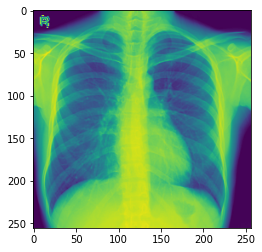

In [ ]:
# 1枚だけ可視化
plt.imshow(data_all[0])

In [ ]:
# 正解データの読み込み
diagnosis1 = pd.read_csv(os.path.join(full_path, "dat0", "diagnosis_new.txt"), sep='\t', header=None)
display(diagnosis1)

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,215A00001,1,異常なし,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,215A00002,1,異常なし,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,215A00004,1,異常なし,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,215A00005,1,異常なし,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,215A00006,2,軽微所見,有,NaN,NaN,RA,右肺尖部,S17,胸膜肥厚（安定）,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82992,218S00508,1,異常なし,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82993,218S00509,1,異常なし,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82994,218S00510,1,異常なし,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82995,218S00511,1,異常なし,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# 同様に、側弯症の所見ありとされた画像のラベルは以下のようにして作れます。
yyy_scoliosis = (diagnosis1[4]=="有").to_numpy().astype(int)

print(f'有：{np.sum(yyy_scoliosis)}　{(np.sum(yyy_scoliosis)/ len(diagnosis1))*100 :.2f}%' ) 

iii_scoliosis = [ np.where(yyy_scoliosis==0)[0], np.where(yyy_scoliosis==1)[0] ]

有：1308　1.58%


In [ ]:
# 正例をサンプリング
sample_index = np.random.choice(iii_scoliosis[0], int(len(iii_scoliosis[0])/10))

In [ ]:
header30 = ("StudyDate","AccessionNumber","StudyID","Modality","StudyDescription","PatientID","PatientsSex","PatientsBirthTime","PatientsAge","PatientsSize","PatientsWeight","ProtocolName","EthnicGroup","Rows","Columns","Sensitivity","BitsAllocated","BitsStored","HighBit","RescaleIntercept","RescaleSlope","RescaleType","WindowCenter","WindowWidth","LossyImageCompression","PixelSpacing","PixelIntensityRelationship","PixelIntensityRelationshipSign","PatientState","ExposedArea")
# data1 のheader
header_dicom_1 = pd.read_csv(os.path.join(full_path, "dat0", "header1_new.txt"), sep='\t', header=None, names=header30)
# data2 のheader
header_dicom_2 = pd.read_csv(os.path.join(full_path, "dat0", "header2_new.txt"), sep='\t', header=None, names=header30)
print(header_dicom_1.shape)
print(header_dicom_2.shape)
display(header_dicom_1.head())
display(header_dicom_2.head())
header_all = pd.concat([header_dicom_1,header_dicom_2], axis=0)
header_all.shape

(50297, 30)
(32700, 30)


,StudyDate,AccessionNumber,StudyID,Modality,StudyDescription,PatientID,PatientsSex,PatientsBirthTime,PatientsAge,PatientsSize,...,RescaleSlope,RescaleType,WindowCenter,WindowWidth,LossyImageCompression,PixelSpacing,PixelIntensityRelationship,PixelIntensityRelationshipSign,PatientState,ExposedArea
0,20150403,215A00001,183715040319094,DX,胸部立位 学生健診２,1,F,NaN,026Y,NaN,...,1.0,US,2047,4096,0,0.13900000000000 0.13900000000000,LOG,1.0,NaN,0.0
1,20150414,215A00002,183715041419248,DX,胸部立位 学生健診２,1,F,NaN,025Y,NaN,...,1.0,US,2047,4096,0,0.13900000000000 0.13900000000000,LOG,1.0,NaN,0.0
2,20150421,215A00004,183715042119265,CR,胸部立位 学生健診２,1,F,NaN,022Y,NaN,...,NaN,NaN,2047,4096,0,0.139 0.139,NaN,NaN,NaN,NaN
3,20150421,215A00005,183715042119266,CR,胸部立位 学生健診２,1,F,NaN,024Y,NaN,...,NaN,NaN,2047,4096,0,0.139 0.139,NaN,NaN,NaN,NaN
4,20150421,215A00006,183715042119267,CR,胸部立位 学生健診２,1,F,NaN,036Y,NaN,...,NaN,NaN,2047,4096,0,0.139 0.139,NaN,NaN,NaN,NaN


,StudyDate,AccessionNumber,StudyID,Modality,StudyDescription,PatientID,PatientsSex,PatientsBirthTime,PatientsAge,PatientsSize,...,RescaleSlope,RescaleType,WindowCenter,WindowWidth,LossyImageCompression,PixelSpacing,PixelIntensityRelationship,PixelIntensityRelationshipSign,PatientState,ExposedArea
0,20130415,213B00001,183713041543894,DX,胸部立位 学生健診１,1,M,NaN,025Y,NaN,...,1.0,US,2047,4096,0,0.13900000000000 0.13900000000000,LOG,1.0,NaN,0.0
1,20130415,213B00002,183713041543895,DX,胸部立位Ｆ 学生健診１,1,M,NaN,025Y,NaN,...,1.0,US,2047,4096,0,0.13900000000000 0.13900000000000,LOG,1.0,NaN,0.0
2,20130521,213B00003,183713052144432,DX,胸部立位 学生健診１,1,F,NaN,034Y,NaN,...,1.0,US,2047,4096,0,0.13900000000000 0.13900000000000,LOG,1.0,NaN,0.0
3,20130521,213B00004,183713052144433,DX,胸部立位 学生健診１,1,F,NaN,029Y,NaN,...,1.0,US,2047,4096,0,0.13900000000000 0.13900000000000,LOG,1.0,NaN,0.0
4,20130521,213B00005,183713052144434,DX,胸部立位 学生健診１,1,F,NaN,025Y,NaN,...,1.0,US,2047,4096,0,0.13900000000000 0.13900000000000,LOG,1.0,NaN,0.0


(82997, 30)

## 学習/テストデータ設定

### 学習データ

In [ ]:
# TARGET作成
TARGET = 'target'

# 目的変数をデータフレーム化
train_df = pd.DataFrame(yyy_scoliosis, columns=[TARGET])

# 交差検証用
n_splits = 5

train_df['kfold'] = -1
y = train_df[TARGET].values
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

for i, (trn_idx, val_idx) in enumerate(skf.split(X=train_df, y=y)):
    train_df.loc[val_idx, 'kfold'] = i

display(train_df)

,target,kfold
0,0,4
1,0,2
2,0,3
3,0,3
4,0,2
...,...,...
82992,0,0
82993,0,3
82994,0,4
82995,0,0


## 動作設定
動作内容の具体的な設定を行います。

In [ ]:
# 基本動作設定
# 早期終了するまでのカウンタ最大値を設定
early_stop = 3    # 本来は10程度がよいが時短
# early_stop = 10

# 最大エポック数を設定（早期終了で終了するため大きい値を設定）
epochs = 10000

# バッチサイズを設定
batch_size = 300

# 前処理の設定
img_resize = (256, 256)

# その他各種設定
# ネットワークを設定（efficientnet-b0固定）
net_type = 'efficientnet_b0'
CLASSES = [0,1]
net = EfficientnetXX(pretrained="imagenet", net_type=net_type, class_num=len(CLASSES))

# デバイスを設定（cpu / cuda）
device = 'cuda'

# ネットワーク構造の可視化
net

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


EfficientnetXX(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_s

In [ ]:
# フォルダ作成するモデル名を設定
model_name = f'{net_type}_20221204'

# モデル出力フォルダの設定
modelpath = f'{full_path}model/{model_name}/'
os.makedirs(modelpath, exist_ok=True)

## 学習
実際に学習を実行します。

In [ ]:
def Train(df, kfold, modelpath, net, epochs, early_stopping, train_bs, valid_bs, image_size=(300,300), device='cpu'):
    # モデル
    model_path = modelpath + f"model_fold_{kfold}.bin"
    os.makedirs(modelpath, exist_ok=True)
    model = net
    if os.path.exists(model_path):
        print(f'Use saved model: {model_path}')
        model.load_state_dict(torch.load(model_path))  #すでに存在している場合は追加学習
    model.to(device)

    # データフレームから情報取得
    df_train = df[df.kfold != kfold]
    df_valid = df[df.kfold == kfold]
    train_targets = df_train[TARGET].values
    valid_targets = df_valid[TARGET].values

    # データセットとデータローダーを用意
    train_dataset = ClassificationDataset(
        image_paths=data_all[df_train.index],
        targets=train_targets,
        resize=img_resize,
        augmentations=train_get_aug(img_resize),
    )

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=train_bs, shuffle=True, num_workers=4
    )

    valid_dataset = ClassificationDataset(
        image_paths=data_all[df_valid.index],
        targets=valid_targets,
        resize=img_resize,
        augmentations=valid_get_aug(img_resize),
    )

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=valid_bs, shuffle=False, num_workers=4
    )

    # その他用意
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        patience=3,
        threshold=0.001,
        mode="max"
    )
    es = EarlyStopping(patience=early_stopping, mode="max")

    # Epoch数分学習実行
    for epoch in range(epochs):
        train_loss = Engine.train(train_loader, model, optimizer, device=device, epoch=epoch)
        predictions, valid_loss = Engine.evaluate(valid_loader, model, device=device, epoch=epoch)
        predictions = np.vstack((predictions))
        auc = roc_auc_score(valid_targets, softmax(predictions))

        time = datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S")
        print(f"[{time}] kFold= {kfold}, Epoch= {epoch}, AUC= {auc:.4f}, Train_loss= {train_loss:.4f}, Valid_loss={valid_loss:.4f}")
        scheduler.step(auc)

        # Early Stoppingの上限数に到達 / 100%正答で途中終了
        es(auc, model, model_path=model_path)
        if es.early_stop:
            print("Early stopping")
            break
        elif auc == 1:
            print("Early stopping")
            break

In [ ]:
# 交差検証で学習実施
for kfold in range(n_splits):
    gc.collect()
    net = EfficientnetXX(pretrained="imagenet", net_type=net_type, class_num=len(CLASSES))

    Train(
        df=train_df,
        kfold=kfold, 
        modelpath=modelpath, 
        net=net,
        epochs=epochs, 
        early_stopping=early_stop, 
        train_bs=batch_size, 
        valid_bs=batch_size, 
        image_size=img_resize, 
        device=device
      )

Use saved model: /content/drive/MyDrive/DiseaseClassification/model/efficientnet_b0_20221204/model_fold_0.bin


  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[2022/12/03 16:39:51] kFold= 0, Epoch= 0, AUC= 0.9777, Train_loss= 0.0252, Valid_loss=0.0331
Validation score improved (-inf --> 0.9777040646121673). Saving model!
[2022/12/03 16:41:50] kFold= 0, Epoch= 1, AUC= 0.9716, Train_loss= 0.0236, Valid_loss=0.0408
EarlyStopping counter: 1 out of 3
[2022/12/03 16:43:50] kFold= 0, Epoch= 2, AUC= 0.9736, Train_loss= 0.0209, Valid_loss=0.0349
EarlyStopping counter: 2 out of 3
[2022/12/03 16:45:49] kFold= 0, Epoch= 3, AUC= 0.9757, Train_loss= 0.0197, Valid_loss=0.0379
EarlyStopping counter: 3 out of 3
Early stopping


  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[2022/12/03 16:47:52] kFold= 1, Epoch= 0, AUC= 0.9749, Train_loss= 0.0804, Valid_loss=0.0316
Validation score improved (-inf --> 0.9748829357681571). Saving model!
[2022/12/03 16:49:51] kFold= 1, Epoch= 1, AUC= 0.9797, Train_loss= 0.0340, Valid_loss=0.0275
Validation score improved (0.9748829357681571 --> 0.9796533440982901). Saving model!
[2022/12/03 16:51:51] kFold= 1, Epoch= 2, AUC= 0.9783, Train_loss= 0.0306, Valid_loss=0.0283
EarlyStopping counter: 1 out of 3
[2022/12/03 16:53:50] kFold= 1, Epoch= 3, AUC= 0.9816, Train_loss= 0.0289, Valid_loss=0.0278
Validation score improved (0.9796533440982901 --> 0.9816467767271356). Saving model!
[2022/12/03 16:55:50] kFold= 1, Epoch= 4, AUC= 0.9744, Train_loss= 0.0263, Valid_loss=0.0310
EarlyStopping counter: 1 out of 3
[2022/12/03 16:57:49] kFold= 1, Epoch= 5, AUC= 0.9805, Train_loss= 0.0249, Valid_loss=0.0269
EarlyStopping counter: 2 out of 3
[2022/12/03 16:59:49] kFold= 1, Epoch= 6, AUC= 0.9810, Train_loss= 0.0230, Valid_loss=0.0280
EarlyS

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[2022/12/03 17:01:52] kFold= 2, Epoch= 0, AUC= 0.9770, Train_loss= 0.0813, Valid_loss=0.0327
Validation score improved (-inf --> 0.9769960166201633). Saving model!
[2022/12/03 17:03:52] kFold= 2, Epoch= 1, AUC= 0.9808, Train_loss= 0.0340, Valid_loss=0.0369
Validation score improved (0.9769960166201633 --> 0.98076646175219). Saving model!
[2022/12/03 17:05:51] kFold= 2, Epoch= 2, AUC= 0.9823, Train_loss= 0.0309, Valid_loss=0.0278
Validation score improved (0.98076646175219 --> 0.9822865528919957). Saving model!
[2022/12/03 17:07:50] kFold= 2, Epoch= 3, AUC= 0.9808, Train_loss= 0.0279, Valid_loss=0.0293
EarlyStopping counter: 1 out of 3
[2022/12/03 17:09:49] kFold= 2, Epoch= 4, AUC= 0.9804, Train_loss= 0.0262, Valid_loss=0.0361
EarlyStopping counter: 2 out of 3
[2022/12/03 17:11:49] kFold= 2, Epoch= 5, AUC= 0.9845, Train_loss= 0.0247, Valid_loss=0.0292
Validation score improved (0.9822865528919957 --> 0.9844902394764996). Saving model!
[2022/12/03 17:13:49] kFold= 2, Epoch= 6, AUC= 0.984

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[2022/12/03 17:19:51] kFold= 3, Epoch= 0, AUC= 0.9742, Train_loss= 0.0772, Valid_loss=0.0338
Validation score improved (-inf --> 0.9741551674890918). Saving model!
[2022/12/03 17:21:50] kFold= 3, Epoch= 1, AUC= 0.9797, Train_loss= 0.0346, Valid_loss=0.0328
Validation score improved (0.9741551674890918 --> 0.9797395442728304). Saving model!
[2022/12/03 17:23:50] kFold= 3, Epoch= 2, AUC= 0.9805, Train_loss= 0.0307, Valid_loss=0.0298
Validation score improved (0.9797395442728304 --> 0.9804730902594566). Saving model!
[2022/12/03 17:25:50] kFold= 3, Epoch= 3, AUC= 0.9831, Train_loss= 0.0299, Valid_loss=0.0311
Validation score improved (0.9804730902594566 --> 0.9830742705931076). Saving model!
[2022/12/03 17:27:50] kFold= 3, Epoch= 4, AUC= 0.9815, Train_loss= 0.0262, Valid_loss=0.0289
EarlyStopping counter: 1 out of 3
[2022/12/03 17:29:49] kFold= 3, Epoch= 5, AUC= 0.9808, Train_loss= 0.0245, Valid_loss=0.0279
EarlyStopping counter: 2 out of 3
[2022/12/03 17:31:49] kFold= 3, Epoch= 6, AUC= 0

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[2022/12/03 17:33:52] kFold= 4, Epoch= 0, AUC= 0.9624, Train_loss= 0.0842, Valid_loss=0.0372
Validation score improved (-inf --> 0.9623602958114559). Saving model!
[2022/12/03 17:35:51] kFold= 4, Epoch= 1, AUC= 0.9726, Train_loss= 0.0338, Valid_loss=0.0367
Validation score improved (0.9623602958114559 --> 0.9726018820202538). Saving model!
[2022/12/03 17:37:51] kFold= 4, Epoch= 2, AUC= 0.9765, Train_loss= 0.0303, Valid_loss=0.0316
Validation score improved (0.9726018820202538 --> 0.9765446018427706). Saving model!
[2022/12/03 17:39:51] kFold= 4, Epoch= 3, AUC= 0.9729, Train_loss= 0.0279, Valid_loss=0.0310
EarlyStopping counter: 1 out of 3
[2022/12/03 17:41:51] kFold= 4, Epoch= 4, AUC= 0.9736, Train_loss= 0.0259, Valid_loss=0.0383
EarlyStopping counter: 2 out of 3
[2022/12/03 17:43:51] kFold= 4, Epoch= 5, AUC= 0.9766, Train_loss= 0.0241, Valid_loss=0.0303
EarlyStopping counter: 3 out of 3
Early stopping


### OOF Predict

In [ ]:
def OOF_Predict(df, kfold, modelpath, net, valid_bs, image_size=(300,300), device='cpu', tta=False):
    # モデル
    model_path = modelpath + f"model_fold_{kfold}.bin"
    model = net
    model.load_state_dict(torch.load(model_path))
    model.to(device)


    # データフレームから情報取得
    df_valid = df[df.kfold == kfold]
    valid_targets = df_valid[TARGET].values

    # データセットとデータローダーを用意
    if tta:
        aug = tta_get_aug(image_size[0], image_size[1])
    else:
        aug = A.Compose([A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=True)])

    valid_dataset = ClassificationDataset(
        image_paths=data_all[df_valid.index],
        targets=valid_targets,
        resize=img_resize,
        augmentations=valid_get_aug(img_resize),
    )

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=valid_bs, shuffle=False, num_workers=4
    )

    # 予測実行
    predict_array = Engine.predict(valid_loader, model, device=device)
    predict_array = np.vstack((predict_array))
    predict_value = np.argmax(predict_array, axis=1)  #multilogloss -> value
    
    return predict_array, predict_value

In [ ]:
# Out of fold スコアの算出関数
def get_oof(modelpath, net, tta):
    oof_array = np.zeros((len(train_df), len(CLASSES)))
    for kfold in tqdm(range(n_splits)):
        _oof_array, _oof_label = OOF_Predict(
            df=train_df,
             kfold=kfold, 
             modelpath=modelpath, 
             net=net, 
             valid_bs=batch_size, 
             image_size=img_resize, 
             device=device,
             tta=tta
        )
        val_idx = train_df[train_df['kfold']==kfold].index
        oof_array[val_idx] = _oof_array
    oof_label = np.argmax(oof_array, axis=1)
    target = np.array(train_df[TARGET])
    print("oof_score AUC : {:.4f}".format(roc_auc_score(target, softmax(oof_array))))
    return oof_array, oof_label

In [ ]:
# スコア算出
oof_array, oof_label = get_oof(modelpath=modelpath, net=net, tta=False)

  0%|          | 0/5 [00:00<?, ?it/s]

oof_score AUC : 0.9785


(array([81820.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  1177.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

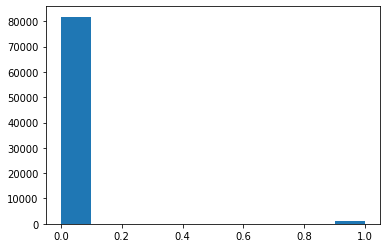

In [ ]:
# 予測結果
plt.hist(oof_label)

(array([81689.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  1308.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

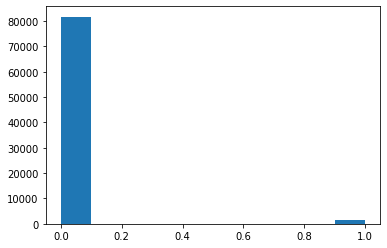

In [ ]:
# 正解
plt.hist(train_df[TARGET])

### Output

In [ ]:
suffix = datetime.datetime.now().strftime("%Y%m%d%H%M") + '.csv'

# Out of fold 結果出力
label = pd.DataFrame(oof_label, columns=['oof_label'])
array = pd.DataFrame(oof_array, columns=CLASSES).round(4)

output_dir = f'{full_path}output/oof/'
os.makedirs(output_dir, exist_ok=True)
label_filepath = f'{output_dir}oof_{model_name}_label_{suffix}'
array_filepath = f'{output_dir}oof_{model_name}_array_{suffix}'
label.to_csv(label_filepath, index=True, header=True)
array.to_csv(array_filepath, index=True, header=True)

print(f'出力結果ファイル：{suffix}')

出力結果ファイル：202212041321.csv


## 予測結果の表示

混同行列：


Text(33.0, 0.5, 'True labels')

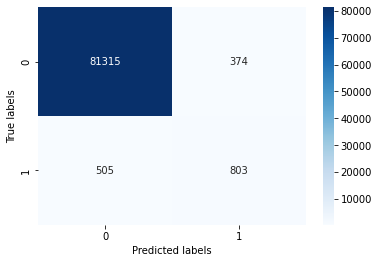

In [ ]:
# 混同行列の表示
cm = confusion_matrix(train_df[TARGET], label)
print(f"混同行列：")
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='d')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')

In [ ]:
# 描画するサンプル画像を指定
sample_num = 10

In [ ]:
def plot_sample(sample):
    if(sample.shape == (256, 256)):
        sample = sample.reshape(1,256,256)
    n_sample = sample.shape[0]
    n_row = n_sample // 5
    n_rem = n_sample % 5
    for aa in range(n_row):
        img_tmp = []
        for bb in range(5):
            img_tmp.append(sample[aa*5+bb])
        img_tmp = np.concatenate(img_tmp, axis=1)
        plt.figure(figsize=(3*5,3))
        plt.imshow(img_tmp, cmap="gray")
        plt.axis("off")
        plt.show()
    
    if(n_rem > 0):
        img_tmp = []
        for bb in range(n_rem):
            img_tmp.append(sample[n_row*5+bb])
        img_tmp = np.concatenate(img_tmp, axis=1)
        plt.figure(figsize=(3*n_rem, 3))
        plt.imshow(img_tmp, cmap="gray")
        plt.axis("off")
        plt.show()

【○正答○】予測：所見有り、医師：所見有り
Int64Index([45, 73, 85, 185, 216, 374, 505, 1044, 1073, 1089], dtype='int64')


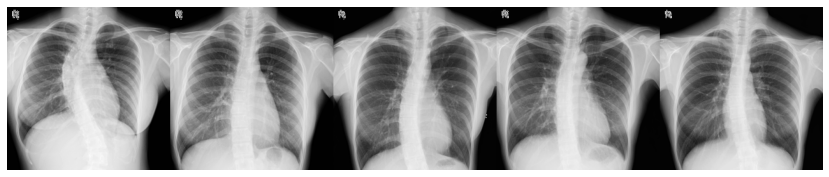

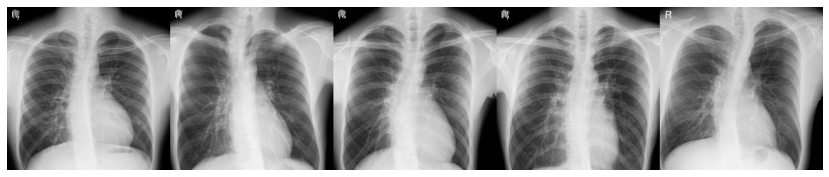


【○正答○】予測：所見なし、医師：所見なし
Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')


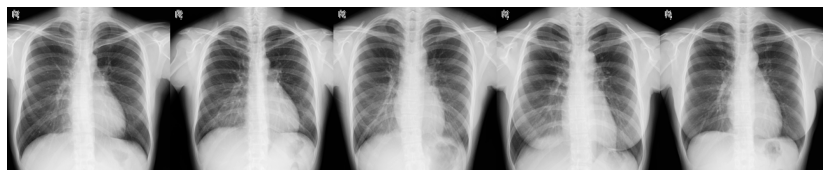

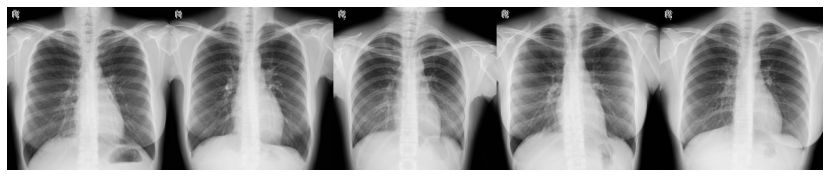


【×誤答×】予測：所見有り、医師：所見なし
Int64Index([37, 89, 102, 140, 203, 240, 337, 345, 348, 488], dtype='int64')


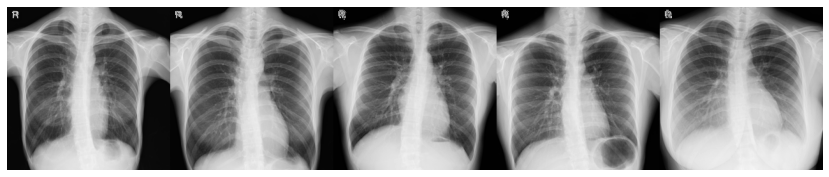

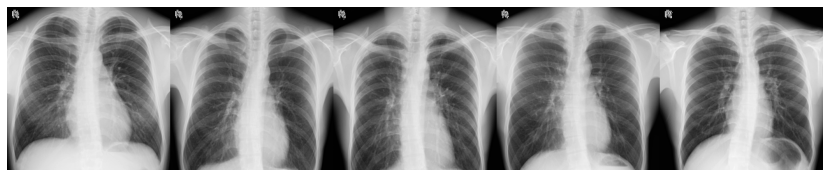


【×誤答×】予測：所見なし、医師：所見有り
Int64Index([454, 719, 784, 1028, 1243, 1928, 1999, 2998, 3025, 3787], dtype='int64')


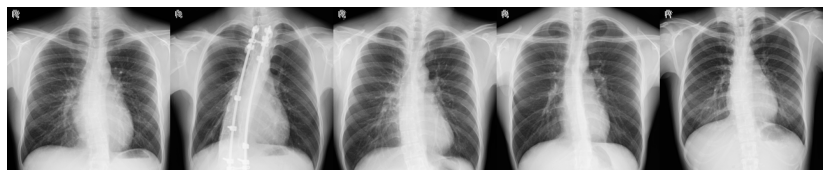

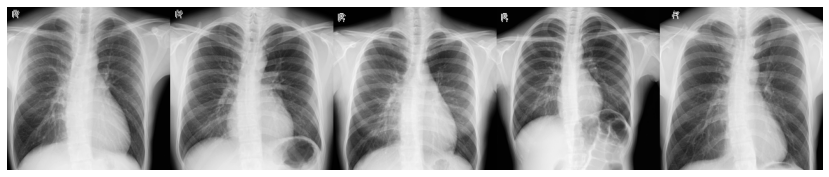

In [ ]:
df_result = pd.concat([train_df[TARGET], label], axis=1)

print("【○正答○】予測：所見有り、医師：所見有り")
mask1 = (df_result['target']==1) & (df_result['oof_label']==1)
sample_idx = df_result[mask1].index[:sample_num]
print(sample_idx)
plot_sample(data_all[sample_idx])

print("\n【○正答○】予測：所見なし、医師：所見なし")
mask1 = (df_result['target']==0) & (df_result['oof_label']==0)
sample_idx = df_result[mask1].index[:sample_num]
print(sample_idx)
plot_sample(data_all[sample_idx])

print("\n【×誤答×】予測：所見有り、医師：所見なし")
mask1 = (df_result['target']==1) & (df_result['oof_label']==0)
sample_idx = df_result[mask1].index[:sample_num]
print(sample_idx)
plot_sample(data_all[sample_idx])

print("\n【×誤答×】予測：所見なし、医師：所見有り")
mask1 = (df_result['target']==0) & (df_result['oof_label']==1)
sample_idx = df_result[mask1].index[:sample_num]
print(sample_idx)
plot_sample(data_all[sample_idx])